In [34]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

!pip install pyLDAvis
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [35]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim

In [36]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [37]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [38]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [39]:
!pip install contractions

In [40]:

# import nltk
# nltk.download('punkt_tab')
# !pip install -U spacy torch transformers
import spacy


In [41]:
# !python -m spacy download en_core_web_trf


In [42]:
df.shape[0]

87034

In [43]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [44]:
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [45]:
df.shape[0]

86446

In [46]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'mild pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-46-b33b4fb1f955>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28679,2021-01-31,mild pos,0.640925,thanks everyonejust security review definitely...,"[thank, everyonejust, security, review, defini...",thank everyonejust security review definitely ...
28682,2021-01-31,mild pos,0.614401,id say san diego might ally decent airline poi...,"[san, diego, ally, decent, airline, point, hot...",san diego ally decent airline point hotel righ...
28692,2021-01-31,mild pos,0.714709,promotion make easy achieve status thought id ...,"[promotion, easy, achieve, status, think, leav...",promotion easy achieve status think leave star...
28698,2021-01-31,mild pos,0.702626,stayed exact property lol like place easy acce...,"[stay, exact, property, lol, like, place, easy...",stay exact property lol like place easy access...
28706,2021-01-30,mild pos,0.747414,booked looked friendly resort picked wailea re...,"[book, look, friendly, resort, pick, wailea, r...",book look friendly resort pick wailea resort f...


In [47]:
high_pos_df.shape[0]

1039

      token  count
0     point    301
1      good    283
2    flight    235
3      like    218
4      book    179
5     thank    176
6    travel    169
7      time    167
8        go    161
9      look    155
10    night    154
11     stay    146
12     well    143
13     trip    141
14      fly    138
15      day    134
16    hotel    132
17    great    128
18    think    127
19     mile    125
20      get    124
21     year    118
22     find    117
23      use    112
24    hyatt    108
25  upgrade    108
26   option    105
27     nice    104
28     card     99
29     room     97


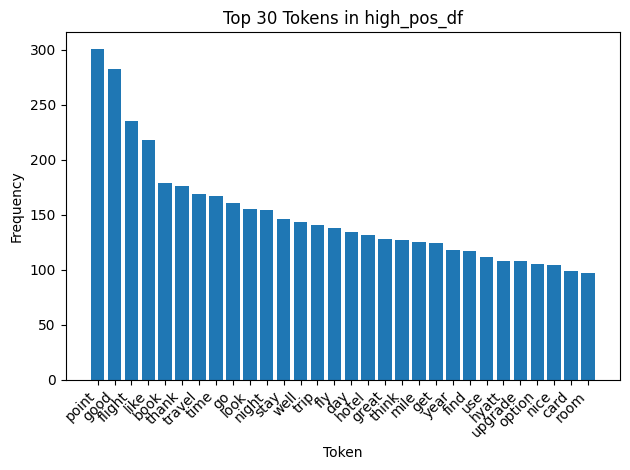

In [48]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [49]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


23716 words total, with a vocabulary size of 4048
Max reddit post length is 451 tokens
Mean reddit post length is 22.83 tokens
Median reddit post length is 15 tokens


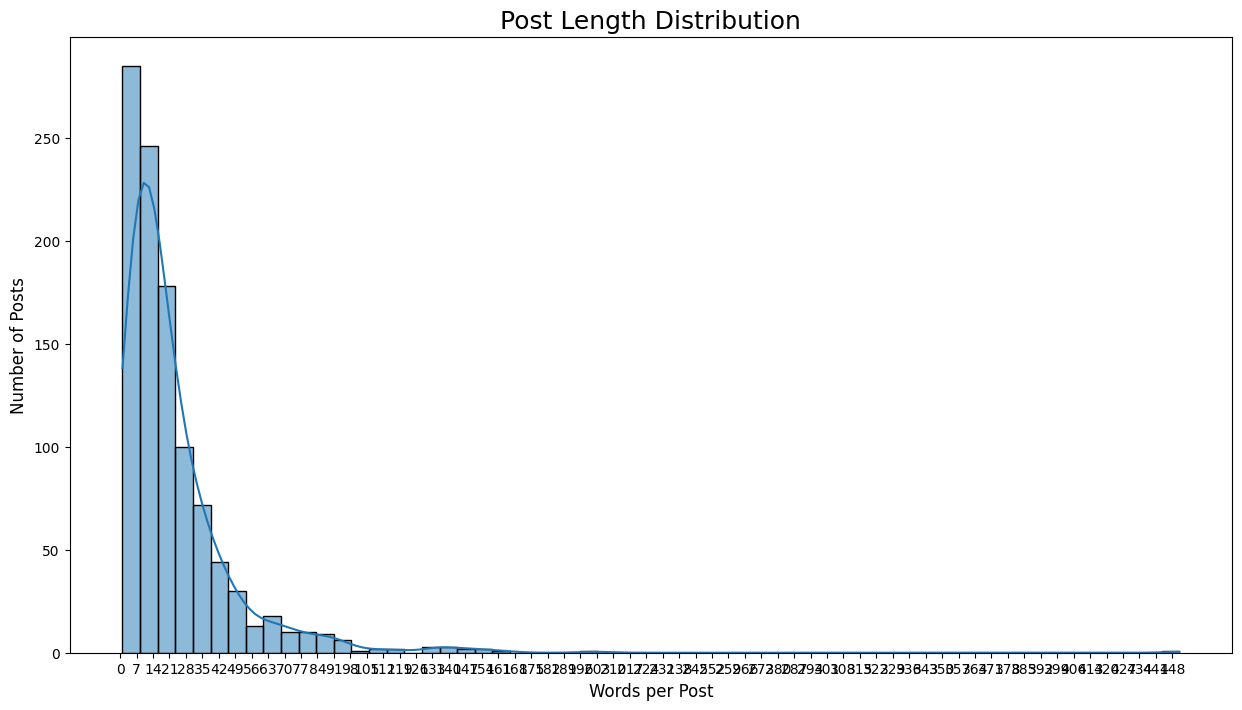

In [50]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [51]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim



In [52]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

#    min_count=3 → only consider pairs that appear in ≥3 docs
#    threshold=50 → higher threshold = fewer, more confident bigrams
# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28679  [thank, everyonejust, security, review, defini...   
28682  [san, diego, ally, decent, airline, point, hot...   
28692  [promotion, easy, achieve, status, think, leav...   
28698  [stay, exact, property, lol, like, place, easy...   
28706  [book, look, friendly, resort, pick, wailea, r...   

                                           bigram_tokens  \
28679  [thank, everyonejust, security, review, defini...   
28682  [san, diego, ally, decent, airline, point, hot...   
28692  [promotion, easy, achieve, status, think, leav...   
28698  [stay, exact, property, lol, like, place, easy...   
28706  [book, look, friendly, resort, pick, wailea, r...   

                                          trigram_tokens  
28679  [thank, everyonejust, security, review, defini...  
28682  [san_diego, ally, decent, airline, point, hote...  
28692  [promotion, easy, achieve, status, think, leav...  
28698  [stay, exact, property, lol, like, 

In [53]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   210
Rows with trigrams:  1
Rows with no n-grams: 829


In [54]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28679,2021-01-31,mild pos,0.640925,thanks everyonejust security review definitely...,"[thank, everyonejust, security, review, defini...",thank everyonejust security review definitely ...,"[thank, everyonejust, security, review, defini...","[thank, everyonejust, security, review, defini...",False,False
28682,2021-01-31,mild pos,0.614401,id say san diego might ally decent airline poi...,"[san, diego, ally, decent, airline, point, hot...",san diego ally decent airline point hotel righ...,"[san, diego, ally, decent, airline, point, hot...","[san_diego, ally, decent, airline, point, hote...",False,False
28692,2021-01-31,mild pos,0.714709,promotion make easy achieve status thought id ...,"[promotion, easy, achieve, status, think, leav...",promotion easy achieve status think leave star...,"[promotion, easy, achieve, status, think, leav...","[promotion, easy, achieve, status, think, leav...",False,False
28698,2021-01-31,mild pos,0.702626,stayed exact property lol like place easy acce...,"[stay, exact, property, lol, like, place, easy...",stay exact property lol like place easy access...,"[stay, exact, property, lol, like, place, easy...","[stay, exact, property, lol, like, place, easy...",False,False
28706,2021-01-30,mild pos,0.747414,booked looked friendly resort picked wailea re...,"[book, look, friendly, resort, pick, wailea, r...",book look friendly resort pick wailea resort f...,"[book, look, friendly, resort, pick, wailea, r...","[book, look, friendly, resort, pick, wailea, r...",True,False


In [55]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1039
Number of rows in 'trigram_tokenized' column: 1039


In [56]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_bigrams = itertools.chain.from_iterable(high_pos_df['bigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
bigram_counts = Counter(
    token for token in all_bigrams
    if isinstance(token, str) and token.count('_') == 1
)

# 3) How many unique trigrams?
total_unique_bigrams = len(bigram_counts)
print(f"Total number of unique bigrams: {total_unique_bigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count:,}")


Total number of unique bigrams: 42

Most common bigrams:
business_class: 25
credit_card: 20
free_breakfast: 17
round_trip: 13
grand_wailea: 11
let_know: 11
suite_upgrade: 11
air_canada: 10
check_bag: 9
award_chart: 8


In [57]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 1

Most common trigrams:
open_hotel_alert: 5


In [58]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [59]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=200,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [60]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [61]:
# from gensim.models import CoherenceModel
# #
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [62]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [63]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [64]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta, seed))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']



print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 9, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.8758, Coherence: 0.3679, Alpha: [0.06326014 0.1208306  0.13861804 0.20439325 0.05910851 0.13931252
 0.01724629 0.07611416 0.13847183], Eta: [0.11495193 0.12766404 0.10328228 ... 0.10809249 0.10809249 0.10809073]

Results:
     num_topics  chunksize  passes  iterations  perplexity  coherence  \
0             2       1000     100          50   -7.523456   0.394895   
1             2       1000     100         100   -7.521389   0.345915   
2             2       1000     100         200   -7.521321   0.345915   
3             2       1000     200          50   -7.516806   0.405401   
4             2       1000     200         100   -7.515630   0.345915   
..          ...        ...     ...         ...         ...        ...   
211           9       1000     200         100   -7.878178   0.365451   
212           9       1000     200         200   -7.878054   0.369556   
213           9       1000     260          

In [65]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4194
 Perplexity: -7.8827
 Alpha (per topic): [0.05022216 0.11001887 0.15763049 0.1331092  0.03147743 0.09930451
 0.0172458  0.10081714 0.14901325]
 Eta   (per word):  [0.10516426 0.148114   0.10322866 ... 0.10810071 0.10810071 0.10809945]


In [67]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 3. Trigger the download
with open('lda_model_full_summary_2nd_mild_pos.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")
    f.flush()  # Ensure it's written to disk

files.download('lda_model_full_summary_2nd_mild_pos.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [69]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.045*"actually" + 0.035*"good" + 0.033*"class" + 0.028*"point" + '
  '0.027*"space" + 0.022*"upgrade" + 0.017*"elite" + 0.017*"buy" + '
  '0.016*"allow" + 0.016*"provide"'),
 (1,
  '0.021*"airport" + 0.021*"good" + 0.020*"fly" + 0.017*"travel" + '
  '0.017*"flight" + 0.016*"go" + 0.015*"think" + 0.015*"etc" + 0.014*"airline" '
  '+ 0.014*"turkish"'),
 (2,
  '0.017*"fly" + 0.013*"seat" + 0.012*"sure" + 0.011*"worth" + 0.011*"flight" '
  '+ 0.011*"day" + 0.010*"time" + 0.009*"point" + 0.009*"direct" + '
  '0.009*"delta"'),
 (3,
  '0.019*"point" + 0.018*"year" + 0.016*"night" + 0.016*"stay" + 0.015*"hotel" '
  '+ 0.013*"hyatt" + 0.013*"time" + 0.012*"good" + 0.012*"room" + 0.011*"use"'),
 (4,
  '0.024*"change" + 0.023*"understand" + 0.020*"make" + 0.019*"quarantine" + '
  '0.018*"slight" + 0.018*"trouble" + 0.018*"anxiety" + 0.004*"reservation" + '
  '0.004*"rock" + 0.004*"saver_space"'),
 (5,
  '0.025*"ticket" + 0.022*"united" + 0.021*"bag" + 0.019*"check" + '
  '

In [70]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [71]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  actually (0.0448)
  good (0.0352)
  class (0.0332)
  point (0.0279)
  space (0.0268)
  upgrade (0.0215)
  elite (0.0175)
  buy (0.0171)
  allow (0.0165)
  provide (0.0163)
  reason (0.0149)
  go (0.0144)
  economy (0.0142)
  stand (0.0142)
  chance (0.0139)
  life (0.0138)
  entitle (0.0122)
  incentive (0.0117)
  distancespace (0.0113)
  naive (0.0113)
  meanthe (0.0113)
  say (0.0100)
  information (0.0095)
  tip (0.0056)
  cert (0.0049)
  deal (0.0047)
  money (0.0040)
  friend (0.0036)
  cat (0.0033)
  season (0.0033)

Topic 2:
  airport (0.0213)
  good (0.0211)
  fly (0.0196)
  travel (0.0174)
  flight (0.0172)
  go (0.0162)
  think (0.0154)
  etc (0.0147)
  airline (0.0140)
  turkish (0.0137)
  qatar (0.0137)
  airway (0.0125)
  well (0.0117)
  want (0.0112)
  problem (0.0112)
  hear (0.0110)
  ask (0.0110)
  maybe (0.0107)
  leave (0.0106)
  stay (0.0104)
  let_know (0.0097)
  mind (0.0089)
  phx (0.0089)
  poland (0.0083)
  close (0.00

In [72]:
# import gensim.corpora as corpora
# # # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# # ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# # #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [73]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50, 100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
#     # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

# print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
#       f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']


# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [74]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [75]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [76]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [77]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [78]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [79]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [80]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'mild neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-80-3d6084a327e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28704,2021-01-31,mild neg,0.677996,new happened edit sorry dont want surf hundred...,"[new, happen, edit, sorry, want, surf, thread]",new happen edit sorry want surf thread
28711,2021-01-30,mild neg,0.631326,ogg x yo x yo wasnt great thing quite far away...,"[ogg, great, thing, far, away, depend, stay, l...",ogg great thing far away depend stay lot time ...
28748,2021-01-29,mild neg,0.622127,seen scattered report account suspension gener...,"[see, scatter, report, account, suspension, ge...",see scatter report account suspension generall...
28767,2021-01-29,mild neg,0.703556,fucking finally lol,"[fucking, finally, lol]",fucking finally lol
28845,2021-01-29,mild neg,0.641328,oof stay extra day la awful red eye,"[oof, stay, extra, day, awful, red, eye]",oof stay extra day awful red eye


In [81]:
high_neg_first_wave_df.shape[0]

957

      token  count
0    flight    311
1   airline    212
2    travel    166
3     point    153
4      book    148
5      like    147
6      time    135
7    cancel    135
8      know    134
9    people    129
10      get    128
11       go    104
12    think    101
13   ticket     95
14      say     91
15      day     90
16      way     90
17      fly     90
18      bad     87
19      try     86
20   credit     85
21   refund     80
22     test     75
23      pay     75
24     want     74
25      use     74
26     trip     72
27    covid     71
28   change     71
29     find     70


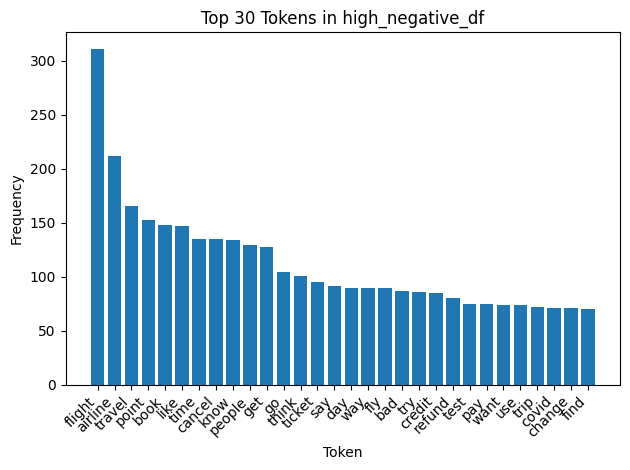

In [82]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [83]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


18514 words total, with a vocabulary size of 3662
Max reddit post length is 263 tokens
Mean reddit post length is 19.35 tokens
Median reddit post length is 14 tokens


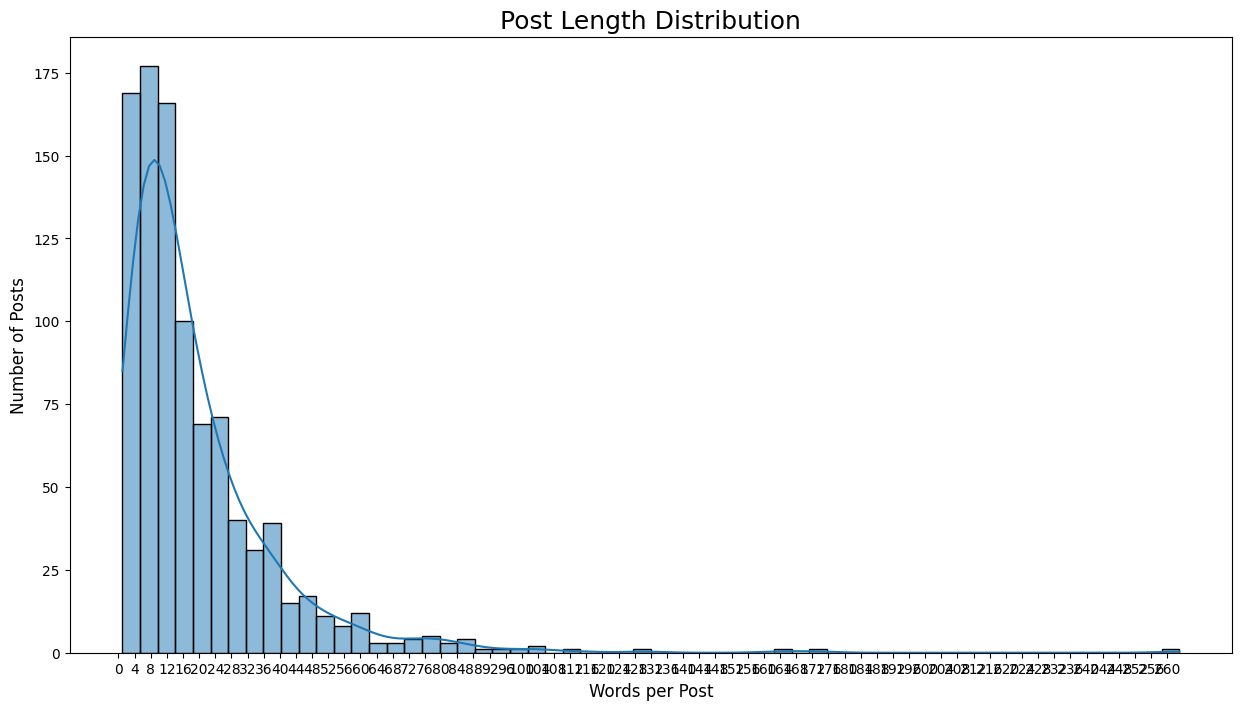

In [84]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [85]:
#!pip install  gensim


In [86]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28704     [new, happen, edit, sorry, want, surf, thread]   
28711  [ogg, great, thing, far, away, depend, stay, l...   
28748  [see, scatter, report, account, suspension, ge...   
28767                            [fucking, finally, lol]   
28845           [oof, stay, extra, day, awful, red, eye]   

                                           bigram_tokens  \
28704     [new, happen, edit, sorry, want, surf, thread]   
28711  [ogg, great, thing, far, away, depend, stay, l...   
28748  [see, scatter, report, account, suspension, ge...   
28767                            [fucking, finally, lol]   
28845           [oof, stay, extra, day, awful, red, eye]   

                                          trigram_tokens  
28704     [new, happen, edit, sorry, want, surf, thread]  
28711  [ogg, great, thing, far, away, depend, stay, l...  
28748  [see, scatter, report, account, suspension, ge...  
28767                            [fucking,

In [87]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   150
Rows with trigrams:  3
Rows with no n-grams: 807


In [88]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28704,2021-01-31,mild neg,0.677996,new happened edit sorry dont want surf hundred...,"[new, happen, edit, sorry, want, surf, thread]",new happen edit sorry want surf thread,"[new, happen, edit, sorry, want, surf, thread]","[new, happen, edit, sorry, want, surf, thread]",False,False
28711,2021-01-30,mild neg,0.631326,ogg x yo x yo wasnt great thing quite far away...,"[ogg, great, thing, far, away, depend, stay, l...",ogg great thing far away depend stay lot time ...,"[ogg, great, thing, far, away, depend, stay, l...","[ogg, great, thing, far, away, depend, stay, l...",False,False
28748,2021-01-29,mild neg,0.622127,seen scattered report account suspension gener...,"[see, scatter, report, account, suspension, ge...",see scatter report account suspension generall...,"[see, scatter, report, account, suspension, ge...","[see, scatter, report, account, suspension, ge...",False,False
28767,2021-01-29,mild neg,0.703556,fucking finally lol,"[fucking, finally, lol]",fucking finally lol,"[fucking, finally, lol]","[fucking, finally, lol]",False,False
28845,2021-01-29,mild neg,0.641328,oof stay extra day la awful red eye,"[oof, stay, extra, day, awful, red, eye]",oof stay extra day awful red eye,"[oof, stay, extra, day, awful, red, eye]","[oof, stay, extra, day, awful, red, eye]",False,False


In [89]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 957
Number of rows in 'trigram_tokenized' column: 957


In [90]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 1

Most common trigrams:
citizen_deny_entry: 3


In [91]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [92]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                           chunksize=250,
#                                        passes=100,
#                                         iterations= 200,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [93]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [94]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [95]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [96]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [300]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta, seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.4275, Coherence: 0.4802, Alpha: [0.04499894 0.0973435 ], Eta: [2.364361  4.622794  5.837254  ... 0.6586701 0.6586701 0.6586701]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4174, Coherence: 0.4574, Alpha: [0.05477398 0.07101787], Eta: [2.410451   5.637708   6.011961   ... 0.66873676 0.66873676 0.66873676]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4092, Coherence: 0.4486, Alpha: [0.05562011 0.05852806], Eta: [2.4290335  5.1301513  5.993375   ... 0.66928214 0.66928214 0.66928214]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.4171, Coherence: 0.4802, Alpha: [0.04125863 0.09021953], Eta: [2.3933973 4.755954  5.903144  ... 0.6625022 0.6625022 0.6625022]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.4074, Coherence: 0.4574, Alpha: [0.04959605 0.06503442], Eta: [2.4373305  5.7904334  6.0727754  ..

In [97]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4837
 Perplexity: -7.7448
 Alpha (per topic): [0.8066667  0.11999153 0.12168894 0.11366676 0.07142103 1.6437415
 0.7269709  0.10421316 0.17067875]
 Eta   (per word):  [0.12329073 0.15054914 0.11049357 ... 0.10771035 0.10771035 0.10771035]


In [98]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_2nd_mild_neg.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_2nd_mild_neg.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [100]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.016*"issue" + 0.014*"pay" + 0.012*"like" + 0.011*"try" + 0.011*"hotel" + '
  '0.010*"check" + 0.010*"say" + 0.009*"company" + 0.009*"case" + '
  '0.009*"post"'),
 (1,
  '0.017*"border" + 0.017*"say" + 0.016*"ana" + 0.010*"intentionally" + '
  '0.008*"okay" + 0.008*"possibility" + 0.008*"set" + 0.008*"circumstance" + '
  '0.007*"way" + 0.007*"man"'),
 (2,
  '0.017*"trouble" + 0.016*"incorrect" + 0.012*"fight" + 0.011*"afford" + '
  '0.010*"imagine" + 0.009*"summer" + 0.009*"open" + 0.009*"marriage" + '
  '0.009*"air" + 0.008*"reject"'),
 (3,
  '0.017*"doubt" + 0.016*"directly" + 0.015*"avianca" + 0.013*"bonus" + '
  '0.013*"august" + 0.011*"quarantine" + 0.011*"health" + 0.010*"handle" + '
  '0.009*"july" + 0.008*"load"'),
 (4,
  '0.018*"national" + 0.016*"level" + 0.011*"area" + 0.009*"subject" + '
  '0.008*"reverse" + 0.008*"denial" + 0.008*"accord" + 0.008*"anymore" + '
  '0.007*"csr" + 0.007*"megathread"'),
 (5,
  '0.029*"airline" + 0.028*"flight" + 0.020*"t

In [101]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [102]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  issue (0.0160)
  pay (0.0145)
  like (0.0115)
  try (0.0114)
  hotel (0.0114)
  check (0.0101)
  say (0.0098)
  company (0.0092)
  case (0.0090)
  post (0.0088)
  know (0.0087)
  agent (0.0085)
  give (0.0080)
  lose (0.0079)
  tell (0.0079)
  chargeback (0.0078)
  problem (0.0074)
  offer (0.0072)
  fee (0.0070)
  card (0.0069)
  bag (0.0069)
  year (0.0069)
  go (0.0067)
  happen (0.0067)
  gate (0.0066)
  chase (0.0066)
  economy (0.0065)
  hyatt (0.0063)
  expect (0.0063)
  possible (0.0063)

Topic 2:
  border (0.0172)
  say (0.0168)
  ana (0.0163)
  intentionally (0.0099)
  okay (0.0085)
  possibility (0.0084)
  set (0.0082)
  circumstance (0.0076)
  way (0.0073)
  man (0.0069)
  additional (0.0069)
  curious (0.0069)
  see (0.0066)
  find (0.0065)
  canada (0.0062)
  box (0.0062)
  traveller (0.0061)
  frustrating (0.0061)
  assure (0.0061)
  custom (0.0059)
  availability (0.0056)
  thread (0.0056)
  inbound (0.0055)
  accurately (0.005

In [103]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [104]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [105]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [106]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [107]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [108]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [109]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [110]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [111]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'mild neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
start_date = '2020-10-01'
end_date = '2021-01-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-111-8b6f68370087>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
28675,2021-01-31,mild neu,0.580842,update mile back tk account woot,"[update, mile, account, woot]",update mile account woot
28677,2021-01-31,mild neu,0.669642,removed,[remove],remove
28680,2021-01-31,mild neu,0.576460,thanks,[thank],thank
28684,2021-01-31,mild neu,0.628082,review guess youve done m recently may facing ...,"[review, guess, recently, face, clawback, wort...",review guess recently face clawback worth call...
28687,2021-01-31,mild neu,0.706279,call usually security verification havent tran...,"[usually, security, verification, transfer]",usually security verification transfer


In [112]:
high_neu_first_wave_df.shape[0]

6173

      token  count
0    flight   1487
1     point    947
2      book    922
3    delete    886
4   airline    861
5    travel    666
6      like    663
7      time    623
8       fly    580
9     think    577
10   ticket    548
11      day    540
12       go    485
13     need    474
14   remove    458
15     mile    455
16      way    455
17     year    450
18     know    446
19    night    440
20     want    439
21     look    438
22    award    438
23    check    435
24     good    432
25      get    413
26   change    412
27    thank    379
28    hotel    375
29      pay    370


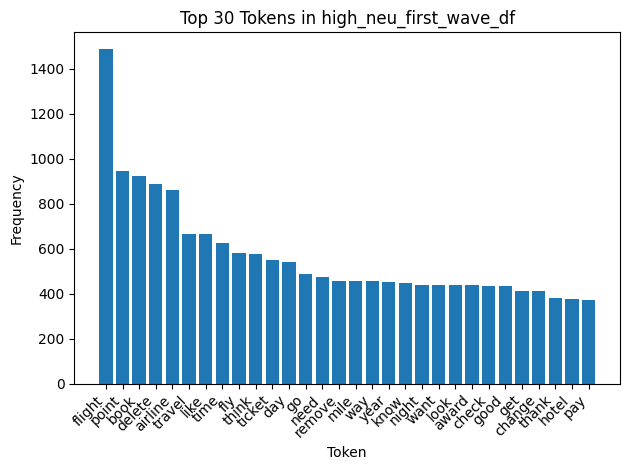

In [113]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [114]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


94046 words total, with a vocabulary size of 8316
Max reddit post length is 305 tokens
Mean reddit post length is 15.24 tokens
Median reddit post length is 8 tokens


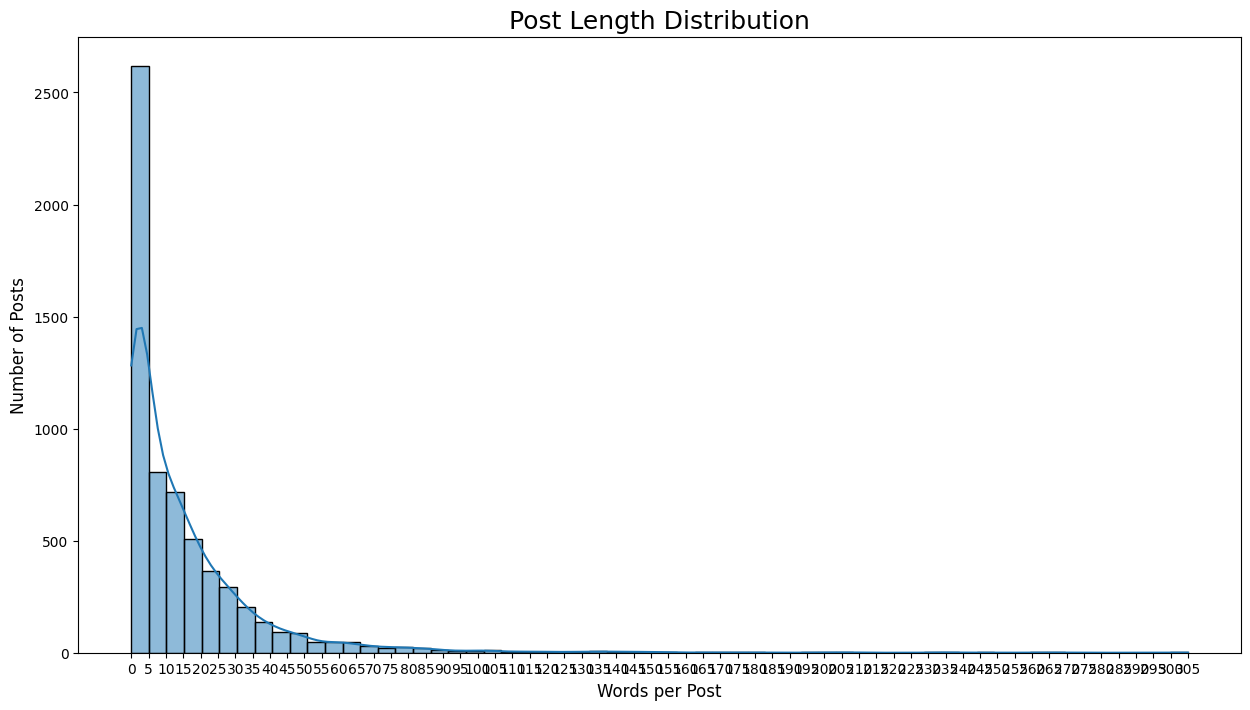

In [115]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

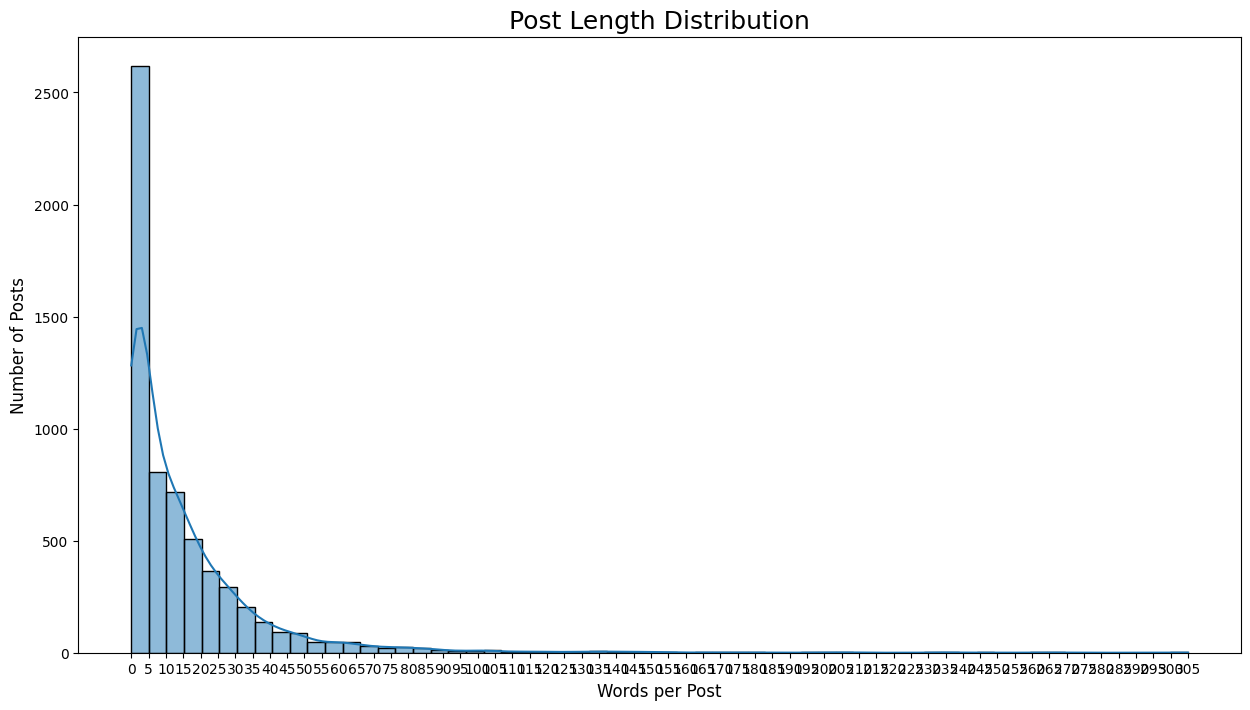

In [116]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [117]:
!pip install  gensim

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


In [118]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
28675                      [update, mile, account, woot]   
28677                                           [remove]   
28680                                            [thank]   
28684  [review, guess, recently, face, clawback, wort...   
28687        [usually, security, verification, transfer]   

                                           bigram_tokens  \
28675                      [update, mile, account, woot]   
28677                                           [remove]   
28680                                            [thank]   
28684  [review, guess, recently, face, clawback, wort...   
28687        [usually, security, verification, transfer]   

                                          trigram_tokens  
28675                      [update, mile, account, woot]  
28677                                           [remove]  
28680                                            [thank]  
28684  [review, guess, recently, face, cla

In [119]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   1213
Rows with trigrams:  59
Rows with no n-grams: 4960


In [120]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28675,2021-01-31,mild neu,0.580842,update mile back tk account woot,"[update, mile, account, woot]",update mile account woot,"[update, mile, account, woot]","[update, mile, account, woot]",False,False
28677,2021-01-31,mild neu,0.669642,removed,[remove],remove,[remove],[remove],False,False
28680,2021-01-31,mild neu,0.576460,thanks,[thank],thank,[thank],[thank],False,False
28684,2021-01-31,mild neu,0.628082,review guess youve done m recently may facing ...,"[review, guess, recently, face, clawback, wort...",review guess recently face clawback worth call...,"[review, guess, recently, face, clawback, wort...","[review, guess, recently, face, clawback, wort...",False,False
28687,2021-01-31,mild neu,0.706279,call usually security verification havent tran...,"[usually, security, verification, transfer]",usually security verification transfer,"[usually, security, verification, transfer]","[usually, security, verification, transfer]",False,False


In [121]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 6173
Number of rows in 'trigram_tokenized' column: 6173


In [122]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 12

Most common trigrams:
remove_contact_mod: 18
negative_test_result: 11
marriott_reward_premier: 6
middle_seat_block: 6
strongly_recommend_list: 5
frequent_flyer_program: 5
original_form_payment: 4
iahlhr_lie_flat: 3
lifetime_titanium_elite: 3
milesif_completely_lose: 3


In [123]:
#import gensim.corpora as corpora
# Create Dictionary
#id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#    (Optional) Re-map the remaining token IDs to remove gaps
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [124]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [125]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [126]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
28675,2021-01-31,mild neu,0.580842,update mile back tk account woot,"[update, mile, account, woot]",update mile account woot,"[update, mile, account, woot]","[update, mile, account, woot]",False,False
28677,2021-01-31,mild neu,0.669642,removed,[remove],remove,[remove],[remove],False,False
28680,2021-01-31,mild neu,0.576460,thanks,[thank],thank,[thank],[thank],False,False
28684,2021-01-31,mild neu,0.628082,review guess youve done m recently may facing ...,"[review, guess, recently, face, clawback, wort...",review guess recently face clawback worth call...,"[review, guess, recently, face, clawback, wort...","[review, guess, recently, face, clawback, wort...",False,False
28687,2021-01-31,mild neu,0.706279,call usually security verification havent tran...,"[usually, security, verification, transfer]",usually security verification transfer,"[usually, security, verification, transfer]","[usually, security, verification, transfer]",False,False


In [127]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [128]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [129]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta', 'seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4124, Coherence: 0.6441 ,Alpha: [0.06646817 0.09195206], Eta: [6.460314   2.914181   4.618829   ... 0.52312994 0.52312994 0.52312994]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4114, Coherence: 0.6465 ,Alpha: [0.05553062 0.08884846], Eta: [6.537784  2.0776472 4.495079  ... 0.5262699 0.5262699 0.5262699]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4126, Coherence: 0.6615 ,Alpha: [0.05633107 0.10138718], Eta: [1.3824499 2.0342057 4.2883244 ... 0.579619  0.579619  0.579619 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4056, Coherence: 0.6469 ,Alpha: [0.06014101 0.08562814], Eta: [6.7229967 3.289463  4.6860385 ... 0.5282262 0.5282262 0.5282262]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.4046, Coherence: 0.6465 ,Alpha: [0.05130303 0.08343866], Eta: [6.792276  2.1076946 4.5640364 ... 0.531129  0.531129  0.531129 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.4041, Coherence: 0.6601 ,Alpha: [0.04742302 0.08603792], Eta: [2.5587447  2.0878346  4.4091587  ... 0.87191284 0.87191284 0.87191284]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.4026, Coherence: 0.6469 ,Alpha: [0.0565601  0.08167445], Eta: [6.828059  3.4657958 4.760387  ... 0.5317216 0.5317216 0.5317216]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.4028, Coherence: 0.6465 ,Alpha: [0.05026029 0.08238662], Eta: [6.82303   2.1142085 4.5798745 ... 0.5322688 0.5322688 0.5322688]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.4018, Coherence: 0.6615 ,Alpha: [0.04435627 0.08063047], Eta: [6.8186293 2.0997756 4.440569  ... 0.5355487 0.5355487 0.5355487]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4425, Coherence: 0.6571 ,Alpha: [0.12837008 0.17636381 0.11398128], Eta: [0.8191533 2.0057483 1.307506  ... 0.3035553 0.3035553 0.3035553]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4383, Coherence: 0.6651 ,Alpha: [0.11325114 0.2221118  0.1081882 ], Eta: [0.9142114  2.0585039  0.9768687  ... 0.28703332 0.28703332 0.28703332]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4961, Coherence: 0.6514 ,Alpha: [0.12897642 0.55151016 0.25340843], Eta: [0.9444994  1.9133083  0.64060646 ... 0.27915338 0.27915338 0.27915338]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4308, Coherence: 0.6647 ,Alpha: [0.11252857 0.15029667 0.097

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4323, Coherence: 0.6630 ,Alpha: [0.13355924 0.08560684], Eta: [ 6.4598827 35.97945    3.8401375 ...  0.4983793  0.4983793  0.4983793]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4322, Coherence: 0.6630 ,Alpha: [0.13314489 0.08547072], Eta: [ 6.430658   35.8492      3.802817   ...  0.49819964  0.49819964
  0.49819964]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4322, Coherence: 0.6627 ,Alpha: [0.13360198 0.0855227 ], Eta: [ 6.4135814  35.71925     3.7971058  ...  0.49799556  0.49799556
  0.49799556]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4251, Coherence: 0.6627 ,Alpha: [0.12351097 0.08137897], Eta: [ 6.6761904 36.795242   3.9091961 ...  0.5028982  0.5028982  0.5028982]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.4251, Coherence: 0.6627 ,Alpha: [0.1233814  0.08158312], Eta: [ 6.6293406  36.681557    3.901006   ...  0.50267863  0.50267863
  0.50267863]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.4252, Coherence: 0.6627 ,Alpha: [0.12490463 0.08241732], Eta: [ 6.618973   36.474422    3.890902   ...  0.50221735  0.50221735
  0.50221735]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.4230, Coherence: 0.6627 ,Alpha: [0.11804432 0.07823253], Eta: [ 7.2113566 37.192677   3.9447987 ...  0.5048238  0.5048238  0.5048238]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.4226, Coherence: 0.6627 ,Alpha: [0.11689073 0.07786904], Eta: [ 7.2170525  37.1703      3.9521785  ...  0.50533664  0.50533664
  0.50533664]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.4226, Coherence: 0.6627 ,Alpha: [0.1166528  0.07776844], Eta: [ 7.213864   37.07064     3.952025   ...  0.50538564  0.50538564
  0.50538564]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4434, Coherence: 0.6817 ,Alpha: [0.161257   0.10031977 0.13525347], Eta: [0.42281848 0.4776692  0.42894882 ... 0.31131896 0.31131896 0.31131896]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4472, Coherence: 0.6823 ,Alpha: [0.16818407 0.10544994 0.20151536], Eta: [0.44062397 0.47837272 0.7350866  ... 0.31115422 0.31115422 0.31115422]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4479, Coherence: 0.6754 ,Alpha: [0.15166534 0.11216988 0.20866068], Eta: [1.043043   1.6407393  1.8127648  ... 0.28412223 0.28412223 0.28412223]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4231, Coherence: 0.6807 ,Alpha: [0.126984

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4353, Coherence: 0.6715 ,Alpha: [0.08766594 0.12247156], Eta: [7.46149    2.2918286  3.1056018  ... 0.49855033 0.49855033 0.49855033]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4353, Coherence: 0.6715 ,Alpha: [0.08587003 0.12339738], Eta: [7.7908998  2.4324672  3.124953   ... 0.49833658 0.49833658 0.49833658]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4354, Coherence: 0.6715 ,Alpha: [0.08154099 0.11974245], Eta: [7.382471  2.2753448 3.1012895 ... 0.4998218 0.4998218 0.4998218]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4266, Coherence: 0.6724 ,Alpha: [0.08011193 0.10669012], Eta: [8.153243   2.3923528  3.359002   ... 0.50441754 0.50441754 0.50441754]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.4261, Coherence: 0.6715 ,Alpha: [0.0772951  0.10589147], Eta: [8.239461   2.56723    3.2974205  ... 0.50517076 0.50517076 0.50517076]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.4260, Coherence: 0.6718 ,Alpha: [0.07409687 0.10280325], Eta: [7.9258018  2.3679464  3.3629649  ... 0.50603646 0.50603646 0.50603646]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.4241, Coherence: 0.6724 ,Alpha: [0.07772482 0.10210937], Eta: [8.397516   2.4289274  3.5528805  ... 0.50605184 0.50605184 0.50605184]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.4239, Coherence: 0.6715 ,Alpha: [0.07578614 0.1027808 ], Eta: [8.44987   2.5813863 3.5372427 ... 0.5064104 0.5064104 0.5064104]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.4239, Coherence: 0.6718 ,Alpha: [0.07277057 0.10012104], Eta: [7.974095   2.389594   3.4155705  ... 0.50725377 0.50725377 0.50725377]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.4483, Coherence: 0.6689 ,Alpha: [0.08733919 0.28988495 0.13116291], Eta: [0.9378358  1.8597487  0.40864184 ... 0.2780976  0.2780976  0.2780976 ]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.4644, Coherence: 0.6209 ,Alpha: [0.09124634 0.36104375 0.10934647], Eta: [0.9520029 1.8937229 0.3917777 ... 0.2793579 0.2793579 0.2793579]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.4673, Coherence: 0.6259 ,Alpha: [0.08558729 0.37561405 0.09846176], Eta: [0.93197256 0.5672455  0.6148888  ... 0.28422737 0.28422737 0.28422737]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.4382, Coherence: 0.6636 ,Alpha: [0.07793513 0.23079443

In [130]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.6823
 Perplexity: -7.4472
 Alpha (per topic): [0.16818407 0.10544994 0.20151536]
 Eta   (per word):  [0.44062397 0.47837272 0.7350866  ... 0.31115422 0.31115422 0.31115422]


In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_neutral_2nd_wave.gensim')


In [132]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_2nd_mild_neu.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_2nd_mild_neu.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [134]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.029*"flight" + 0.022*"book" + 0.018*"airline" + 0.016*"ticket" + '
  '0.010*"fly" + 0.010*"mile" + 0.010*"remove" + 0.009*"seat" + 0.009*"point" '
  '+ 0.008*"refund"'),
 (1,
  '0.054*"delete" + 0.023*"point" + 0.021*"night" + 0.014*"hotel" + '
  '0.013*"stay" + 0.010*"upgrade" + 0.010*"status" + 0.009*"hyatt" + '
  '0.008*"room" + 0.008*"year"'),
 (2,
  '0.014*"flight" + 0.010*"time" + 0.010*"thank" + 0.009*"travel" + '
  '0.008*"airport" + 0.008*"day" + 0.008*"need" + 0.008*"check" + 0.007*"fly" '
  '+ 0.007*"think"')]

Sample doc-topic distribution for doc 0:
[(0, 0.9312306), (1, 0.023616696), (2, 0.045152742)]


In [135]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [136]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  flight (0.0294)
  book (0.0215)
  airline (0.0185)
  ticket (0.0161)
  fly (0.0104)
  mile (0.0102)
  remove (0.0098)
  seat (0.0094)
  point (0.0087)
  refund (0.0081)
  change (0.0080)
  cancel (0.0080)
  award (0.0070)
  way (0.0066)
  travel (0.0065)
  pay (0.0059)
  price (0.0059)
  like (0.0057)
  look (0.0054)
  transfer (0.0054)
  find (0.0053)
  delta (0.0049)
  use (0.0049)
  united (0.0048)
  route (0.0048)
  buy (0.0046)
  want (0.0046)
  think (0.0046)
  trip (0.0046)
  option (0.0045)

Topic 2:
  delete (0.0536)
  point (0.0233)
  night (0.0211)
  hotel (0.0137)
  stay (0.0125)
  upgrade (0.0099)
  status (0.0097)
  hyatt (0.0086)
  room (0.0079)
  year (0.0077)
  like (0.0073)
  free (0.0072)
  pay (0.0058)
  marriott (0.0058)
  property (0.0052)
  value (0.0048)
  worth (0.0046)
  suite (0.0046)
  think (0.0045)
  hilton (0.0044)
  get (0.0043)
  use (0.0042)
  card (0.0041)
  day (0.0037)
  well (0.0037)
  spend (0.0035)
  ear

In [137]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [138]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()

#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [139]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [140]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [141]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [142]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [143]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [144]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [145]:
# ## FIND THE OPTIMAL TOPIC

# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd

# # Assuming high_neu_first_wave_df['lemmatized_bigrams'] contains lists of lemmatized bigram tokens
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Create a Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus,
#                                        id2word=dictionary,
#                                        num_topics=num_topics,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)
#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#     return perplexity, coherence

# # Testing different numbers of topics
# results = []
# for num_topics in range(2, 12):  # You can adjust the range based on your needs
#     perplexity, coherence = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics)
#     results.append((num_topics, perplexity, coherence))

# # Display results
# print("Num Topics | Perplexity | Coherence")
# for result in results:
#     print(f"{result[0]:10d} | {result[1]:10.4f} | {result[2]:10.4f}")

# # Optional: find the number of topics with the highest coherence
# optimal_num_topics = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
# print(f"Optimal Number of Topics: {optimal_num_topics}")


In [146]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()